# COVID-19 Global Forecasting

- Goal:

Find variables that look like they impact the transmission rate for [this]() Kaggle competition.


- Features:

1. Days since first case and first death - 0, 1, 2, 3...
2. Nc = Number of cases/deaths on a given day (total - previous day total)
3. Growth factor: Nc/(Nc previous day) (inspired by this [video](https://www.youtube.com/watch?v=Kas0tIxDvrg))
4. Average temperature for each place (january and february. My original intention was to analyse daily temperatures and see how that affected the number of new cases and deaths)
5. Confirmed cases/Population size
6. Other variables from [World Health Organization](https://data.worldbank.org/indicator)
    * Population (total, female, urban)
    * Land area
    * GDP per Capita
    * Smoking prevalence (total, female, male)

Densidade demográfica, renda per capita, average population age, male-female distribution, blood type, alcohol consumption

Author 
- Viviane Sanchez

In [4]:
import requests, json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import os

# Exploratory Analysis

### Data processing

In [5]:
confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [6]:
fatalities_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

In [7]:
c = pd.read_csv(confirmed_url)

In [8]:
f = pd.read_csv(fatalities_url)

In [9]:
def ajusta_base(df, case, group = True):
    df['Country/Region'] = df['Country/Region'].str.replace('*','')
    df['Country/Region'] = df['Country/Region'].str.replace(', The','')

    if group == False:
        base = pd.melt(df, id_vars = ['Province/State','Country/Region','Lat','Long'], var_name = 'Date', value_name = case )
    else:
        grouped = df.groupby('Country/Region').sum().reset_index()
        base = pd.melt(grouped, id_vars = ['Country/Region','Lat','Long'], var_name = 'Date', value_name = case )
        
    base['Date'] = pd.to_datetime(base['Date'], format='%m/%d/%y')
    
    return base

In [11]:
df = ajusta_base(c, 'Confirmed', False)

In [15]:
df['Fatalities'] = ajusta_base(f,'Fatalities',False)['Fatalities']

In [16]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Fatalities
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2.0,0.0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2.0,0.0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0.0,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31062 entries, 0 to 31061
Data columns (total 7 columns):
Province/State    20274 non-null object
Country/Region    31062 non-null object
Lat               31062 non-null float64
Long              31062 non-null float64
Date              31062 non-null datetime64[ns]
Confirmed         30870 non-null float64
Fatalities        30870 non-null float64
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.7+ MB


In [18]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d') #adjusting format

In [19]:
df['Country/Region'] = df['Country/Region'].str.replace('*','') #adjusting Taiwan's name

In [20]:
#checking which countries have state
df['Country/Region'][df['Province/State'].notnull()].unique()

array(['Canada', 'Australia', 'US', 'China', 'France', 'Cruise Ship',
       'Denmark', 'United Kingdom', 'Netherlands'], dtype=object)

In [21]:
df['Province/State'][df['Country/Region'] == 'Denmark'].unique()

array(['Denmark', 'Faroe Islands', 'Greenland'], dtype=object)

In [22]:
for country in df['Country/Region'][df['Province/State'].notnull()].unique():
    print ('Country:',country)
    states = df['Province/State'][df['Country/Region'] == country].unique()
    print('States:', states)

Country: Canada
States: ['British Columbia' 'Ontario' 'Alberta' 'Quebec' 'New Brunswick'
 'Manitoba' 'Saskatchewan' 'Grand Princess' 'Newfoundland and Labrador'
 'Prince Edward Island' 'Nova Scotia' 'Northwest Territories']
Country: Australia
States: ['New South Wales' 'Victoria' 'Queensland' 'South Australia'
 'From Diamond Princess' 'Western Australia' 'Tasmania'
 'Northern Territory' 'Australian Capital Territory']
Country: US
States: ['Washington' 'New York' 'California' 'Massachusetts' 'Diamond Princess'
 'Grand Princess' 'Georgia' 'Colorado' 'Florida' 'New Jersey' 'Oregon'
 'Texas' 'Illinois' 'Pennsylvania' 'Iowa' 'Maryland' 'North Carolina'
 'South Carolina' 'Tennessee' 'Virginia' 'Arizona' 'Indiana' 'Kentucky'
 'District of Columbia' 'Nevada' 'New Hampshire' 'Minnesota' 'Nebraska'
 'Ohio' 'Rhode Island' 'Wisconsin' 'Connecticut' 'Hawaii' 'Oklahoma'
 'Utah' 'Kansas' 'Louisiana' 'Missouri' 'Vermont' 'Alaska' 'Arkansas'
 'Delaware' 'Idaho' 'Maine' 'Michigan' 'Mississippi' 'Montana

- Since UK, Netherlands and France have regions that are outside the land territory, those will be treated separately.
- Australia, Canada, China and US states will be grouped.

In [23]:
country = ['Denmark', 'France','Netherlands','United Kingdom']
df['Region'] = np.where(df['Country/Region'].isin(country),df['Province/State'],df['Country/Region'])
#df['Region'] = np.select(conditions, choices)

In [24]:
#checking those countries:
for country in df['Country/Region'][df['Province/State'].notnull()].unique():
    print ('Country:', country)
    region = df['Region'][df['Country/Region'] == country].unique()
    print('Region:', region)

Country: Canada
Region: ['Canada']
Country: Australia
Region: ['Australia']
Country: US
Region: ['US']
Country: China
Region: ['China']
Country: France
Region: ['France' 'St Martin' 'Saint Barthelemy' 'French Polynesia'
 'French Guiana' 'Mayotte' 'Guadeloupe' 'Reunion' 'New Caledonia']
Country: Cruise Ship
Region: ['Cruise Ship']
Country: Denmark
Region: ['Denmark' 'Faroe Islands' 'Greenland']
Country: United Kingdom
Region: ['Channel Islands' 'Gibraltar' 'United Kingdom' 'Cayman Islands'
 'Montserrat' 'Bermuda' 'Isle of Man']
Country: Netherlands
Region: ['Netherlands' 'Curacao' 'Aruba' 'Sint Maarten']


* Grouping de dataset by date and country

In [27]:
df2 = df.groupby(['Date','Region'])[["Confirmed", "Fatalities"]].sum().reset_index() #id, latitude and longitude

In [28]:
df2.sort_values(['Region','Date'], inplace = True)

In [29]:
df2[df2['Region'] == 'US']

,Date,Region,Confirmed,Fatalities
186,2020-01-22,US,1.0,0.0
383,2020-01-23,US,1.0,0.0
580,2020-01-24,US,2.0,0.0
777,2020-01-25,US,2.0,0.0
974,2020-01-26,US,5.0,0.0
...,...,...,...,...
11415,2020-03-19,US,13677.0,200.0
11612,2020-03-20,US,19100.0,244.0
11809,2020-03-21,US,25489.0,307.0
12006,2020-03-22,US,33272.0,417.0


## Features

1. Find out the date of the first case and first fatality for each country, so can normalize the spread from the first case and remove the delay effect.

In [30]:
def first_case(df,place_id,col,place):
    min_cases = df[col][df[col] != 0][df[place] == place_id]
    if len(min_cases) == 0:
        min_cases = 0
        date = df['Date'][df[place] == place_id].max()
        #print('0:', place_id, date)
    else:
        min_cases = df[col][df[col] != 0][df[place] == place_id].min()
        date = df['Date'][df[col] == min_cases][df[place] == place_id].min()
        #print(min_cases, place_id, date)
    return date

In [32]:
first_cases = {}
deaths = {}
place = 'Region' # 'Province/State' or 'Country/Region'
for country in df[place].unique():
    date = first_case(df2, country,'Confirmed',place)
    date_death = first_case(df2, country,'Fatalities',place)
    first_cases[country] = date #where there's no case/death yet, the lastest date is considered
    deaths[country] = date_death

In [33]:
#Correcting the dates of the first case and first death of China

In [34]:
#first_cases['China'] = 2019-12-??

In [35]:
df2['1st_case'] = df2[place].map(first_cases)
df2['1st_fatality'] = df2[place].map(deaths)

In [36]:
df2['Days_since_1st_case'] = (df2['Date'] - df2['1st_case']).dt.days
df2['Days_since_1st_fatality'] = (df2['Date'] - df2['1st_fatality']).dt.days

No handles with labels found to put in legend.


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

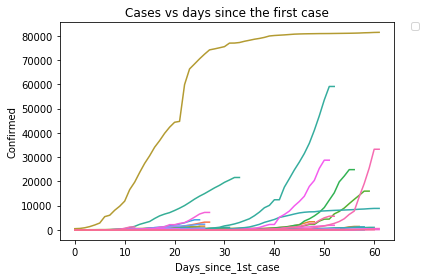

In [38]:
sns.lineplot(x='Days_since_1st_case', y="Confirmed",
             hue="Region", legend = False,
             data = df2[df2['Days_since_1st_case'] >= 0])

plt.title('Cases vs days since the first case')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)

#As we can see, in some countries the spread took longer to break

No handles with labels found to put in legend.


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

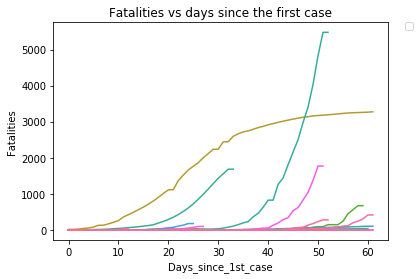

In [39]:
sns.lineplot(x='Days_since_1st_case', y="Fatalities",
             hue="Region", legend = False,
             data = df2[df2['Days_since_1st_case'] >= 0])
plt.title('Fatalities vs days since the first case')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)

2. Daily new cases and fatalities

In [40]:
def daily_var(df, column_name, common_value,shift_value):
    df[column_name] = np.where(df[common_value] == df[common_value].shift(1), df[shift_value].diff(1),0)

In [42]:
daily_var(df2,'new_cases','Region','Confirmed')

In [43]:
daily_var(df2,'new_fatalities','Region','Fatalities')

No handles with labels found to put in legend.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text xticklabel objects>)

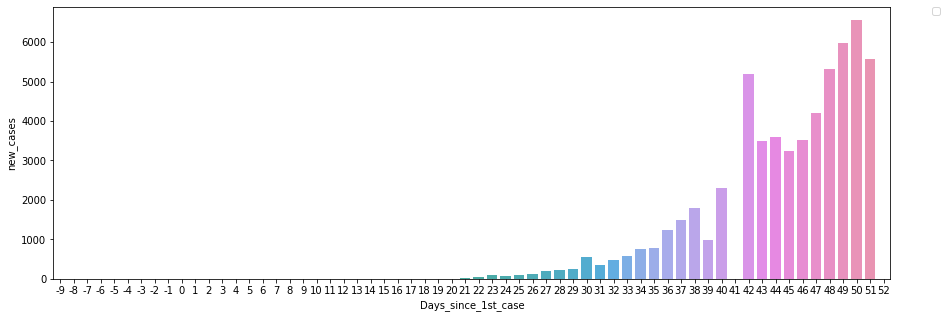

In [44]:
plt.figure(figsize=(15, 5))
sns.barplot(x = 'Days_since_1st_case', y = 'new_cases', data = df2[df2['Region'] == 'Italy'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)

In [45]:
def daily_evolution(df,region):
    labels = df['Days_since_1st_case'][df['Region'] == region].unique()
    cases = df['new_cases'][df['Region'] == region]
    #fatalities = df['new_fatalities'][df['Region'] == region]
    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, cases, width, label='Cases')
    #ax.bar(labels, fatalities, width, bottom=cases,label='Fatalities')

    ax.set_ylabel('Total')
    ax.set_xlabel('Days since 1st case')
    ax.set_title('New cases by day in ' + region)
    ax.legend()

    plt.show()

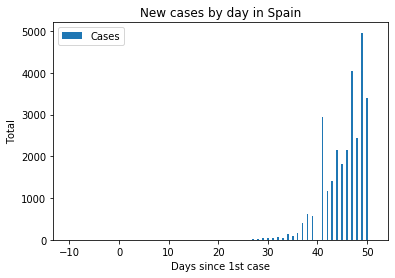

In [46]:
daily_evolution(df2,'Spain')

3. Growth Factor

In [47]:
def growth_factor(df, column_name, place,shift_value):
    df[column_name] = np.where(df[place] == df[place].shift(1), df[shift_value].div(df[shift_value].shift(1)),0)
    df[column_name].replace([np.inf,-np.inf],np.nan, inplace = True)
    df[column_name].fillna(method = 'ffill', inplace = True)

In [48]:
#growth factor moving average
def GFMA(df, column_name, place,shift_value, wndw):
    df[column_name] = np.where(df[place] == df[place].shift(1), df[shift_value].rolling(window = wndw).mean(),0)
    df[column_name].fillna(method = 'ffill', inplace = True)

In [49]:
growth_factor(df2,'growth_factor','Region','new_cases')
GFMA(df2,'GFMA','Region','growth_factor',14) #14 days because theoretically that's how long it takes for the virus to be killed in our organism
growth_factor(df2,'growth_factor_f','Region','new_fatalities')
GFMA(df2,'GFMA_f','Region','growth_factor_f',14)

In [50]:
df2.head()

,Date,Region,Confirmed,Fatalities,1st_case,1st_fatality,Days_since_1st_case,Days_since_1st_fatality,new_cases,new_fatalities,growth_factor,GFMA,growth_factor_f,GFMA_f
0,2020-01-22,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-33,-60,0.0,0.0,0.0,0.0,0.0,0.0
197,2020-01-23,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-32,-59,0.0,0.0,0.0,0.0,0.0,0.0
394,2020-01-24,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-31,-58,0.0,0.0,0.0,0.0,0.0,0.0
591,2020-01-25,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-30,-57,0.0,0.0,0.0,0.0,0.0,0.0
788,2020-01-26,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-29,-56,0.0,0.0,0.0,0.0,0.0,0.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text xticklabel objects>)

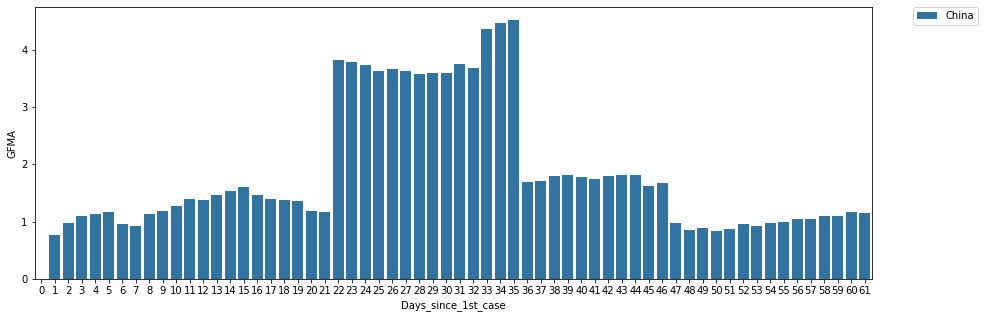

In [51]:
plt.figure(figsize=(15, 5))
sns.barplot(x = 'Days_since_1st_case', y = 'GFMA', hue = 'Region', data = df2[df2['Region'] == 'China'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)

As we can see in China, at first the growth factor was very big, but eventually it decreased, making the curve stop The moving average helps us see that too.

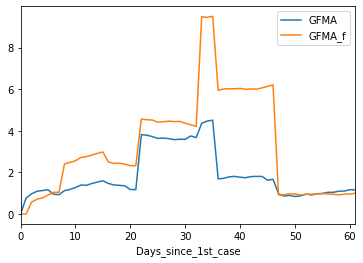

In [53]:
df2[df2['Region'] == 'China'].plot(x = 'Days_since_1st_case', y = ['GFMA','GFMA_f'])

## Outside Variables

### 1. Weather

My original intention was to analyse daily weather and see how that affected the number of new cases and deaths. But giving that this is a very complex process that involves APIs and data tidying, I found it better to check if temperature would actually play a role in the spread. This could be replicated to wind speed, solar radiation, rain, etc. I got the temperatures from [Wikipedia.](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) Feel free to gather data from other sources if you can.

1.1 Web Scraping

In [54]:
avg_temp_url = 'https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature'
wiki_text = requests.get(avg_temp_url).text
soup = bs(wiki_text, 'html.parser')
tables = soup.find_all('table')
table_str = str(tables)

In [55]:
continents = []
for i in range (0,6):
    t = pd.read_html(table_str)[i]
    continents.append(t)
temps = pd.concat(continents)
temps.drop('Ref.', axis = 1, inplace = True)

In [56]:
#adjusting names
temps['Country'].replace(['United States'],'US', inplace = True)
temps['Country'].replace(['United ArabEmirates'],'United Arab Emirates', inplace = True)
temps['Country'].replace(['South Korea'],'Korea, South', inplace = True)
temps['Country'].replace(['The '],'', inplace = True)

In [57]:
for month in temps.iloc[:,2:].columns:
    temps[month] = temps[month].str.replace('−','-').str.split('(', expand = True)[0]
    #temps[month] = temps[month].apply(pd.to_numeric, errors='ignore')

In [58]:
temps = temps.apply(pd.to_numeric, errors = 'ignore')

In [59]:
avg_temps = temps.groupby('Country').mean() #monthly average for each country

No handles with labels found to put in legend.


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171]), <a list of 172 Text xtickl

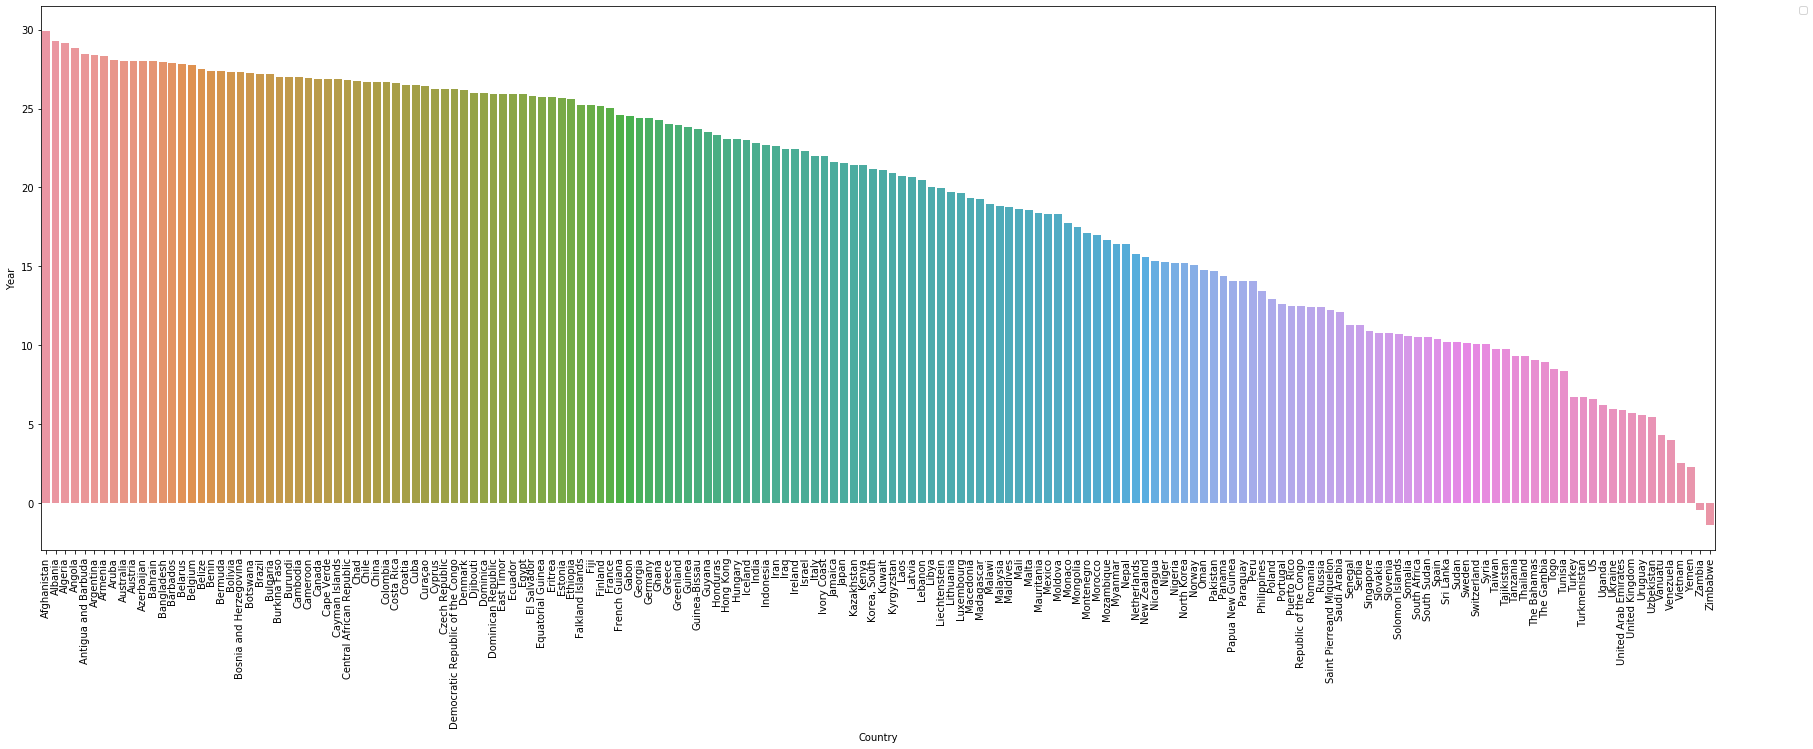

In [60]:
plt.figure(figsize=(30, 10))

sns.barplot(x = avg_temps.index, y = 'Year', data = avg_temps.sort_values('Year', ascending = False))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)

### 2. World Health Organization

I selected random datasets from the WHO [database](https://data.worldbank.org/indicator) to check if any of those have any influence. Ideally, the model would check all of them.

In [61]:
def replace_names_who(df):
    df['Country Name'].replace(['United States'],'US', inplace = True)
    #temps['Country'].replace(['United ArabEmirates'],'United Arab Emirates', inplace = True)
    #temps['Country'].replace(['South Korea'],'Korea, South', inplace = True)
    #temps['Country'].replace(['The '],'', inplace = True)

### Consolidating variables and dataset

Since all those variables are mostly a single value for each year, I've decided to aggregate the training dataset to the latest available date. This way we can measure the influence of each one considering how far the spread was at that point.

In [62]:
latest = df2['Date'].max()
latest

Timestamp('2020-03-23 00:00:00')

In [63]:
df_latest = df2[df2['Date'] == latest].copy()

In [64]:
df_latest.sort_values('growth_factor', inplace = True, ascending = False)

In [65]:
df_latest.head()

,Date,Region,Confirmed,Fatalities,1st_case,1st_fatality,Days_since_1st_case,Days_since_1st_fatality,new_cases,new_fatalities,growth_factor,GFMA,growth_factor_f,GFMA_f
12054,2020-03-23,China,81439.0,3274.0,2020-01-22,2020-01-22,61,61,42.0,9.0,0.456522,1.156995,1.5,1.006725
12047,2020-03-23,Canada,1470.0,21.0,2020-01-26,2020-03-09,57,14,5.0,0.0,0.026738,3.231943,0.0,0.663265
12203,2020-03-23,US,33276.0,417.0,2020-01-22,2020-02-29,61,23,4.0,0.0,0.000514,1.650086,0.0,1.979155
12017,2020-03-23,Afghanistan,40.0,1.0,2020-02-24,2020-03-22,28,1,0.0,0.0,0.000000,0.317857,0.0,0.000000
12152,2020-03-23,Nigeria,30.0,0.0,2020-02-28,2020-03-23,24,0,0.0,0.0,0.000000,0.592857,0.0,0.000000


Reading all files...

In [66]:
files = os.listdir('Kaggle/who')

In [67]:
for i in range(1, len(files)):
    file = 'Kaggle/who/' + files[i]
    name = files[i][:-4]
    temp = pd.read_csv(file, skiprows = 3)
    replace_names_who(temp)
    temp.head()
    
    #finds the column with the latest data
    row = 2
    while temp[temp.columns[-row]].notnull().mean() == 0:
        col = temp.columns[-row]
        #print(name,'row:',row, 'mean:' )
        #print(temp[temp.columns[-row]].notnull().mean())
        row += 1
        #print('new row:',row)
        
    temp.set_index('Country Name', inplace = True)
    col = temp.columns[-row]
    #print('col:',col)
    #print(temp[col])
    
    #consolidating dataset
    df_latest[name] = df_latest['Region'].map(temp[col])
    df_latest[name].fillna(temp.loc['World',col], inplace = True) #fills empty values with World mean
    
    df2[name] = df2['Region'].map(temp[col])
    df2[name].fillna(temp.loc['World', col], inplace = True)

In [68]:
df_latest['Avg_temp'] = df_latest['Region'].map(avg_temps[['Jan','Feb']].mean(axis = 1))
df_latest['Avg_temp'] = df_latest['Avg_temp'].fillna(df_latest['Avg_temp'].mean())#fills empty values with global mean

df2['Avg_temp'] = df2['Region'].map(avg_temps[['Jan','Feb']].mean(axis = 1))
df2['Avg_temp'] = df2['Avg_temp'].fillna(df2['Avg_temp'].mean())#fills empty values with global mean

In [69]:
df_latest.head()

,Date,Region,Confirmed,Fatalities,1st_case,1st_fatality,Days_since_1st_case,Days_since_1st_fatality,new_cases,new_fatalities,...,population_growth,land_area,smoking_female,total_population,gdp_per_capita,life_expectancy,female_population,urban_population,alcohol_consumption,Avg_temp
12054,2020-03-23,China,81439.0,3274.0,2020-01-22,2020-01-22,61,61,42.0,9.0,...,0.455900,22.353942,1.900000,1.392730e+09,9770.847088,76.470000,48.679374,823827650.0,7.2,0.360000
12047,2020-03-23,Canada,1470.0,21.0,2020-01-26,2020-03-09,57,14,5.0,0.0,...,1.409247,38.161547,12.000000,3.705886e+07,46232.989623,82.248976,50.391530,30169985.0,8.9,-11.636667
12203,2020-03-23,US,33276.0,417.0,2020-01-22,2020-02-29,61,23,4.0,0.0,...,0.619431,33.929786,19.100000,3.271674e+08,62794.585652,78.539024,50.520015,269114845.0,9.8,5.542308
12017,2020-03-23,Afghanistan,40.0,1.0,2020-02-24,2020-03-22,28,1,0.0,0.0,...,2.384761,2.067825,6.448615,3.717239e+07,520.896603,64.130000,48.635847,9477100.0,0.2,-1.500000
12152,2020-03-23,Nigeria,30.0,0.0,2020-02-28,2020-03-23,24,0,0.0,0.0,...,2.586546,7.228389,0.600000,1.958747e+08,2028.181970,53.950000,49.336114,98611179.0,13.4,26.260000


In [70]:
df2.head()

,Date,Region,Confirmed,Fatalities,1st_case,1st_fatality,Days_since_1st_case,Days_since_1st_fatality,new_cases,new_fatalities,...,population_growth,land_area,smoking_female,total_population,gdp_per_capita,life_expectancy,female_population,urban_population,alcohol_consumption,Avg_temp
0,2020-01-22,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-33,-60,0.0,0.0,...,2.384761,2.067825,6.448615,37172386.0,520.896603,64.13,48.635847,9477100.0,0.2,-1.5
197,2020-01-23,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-32,-59,0.0,0.0,...,2.384761,2.067825,6.448615,37172386.0,520.896603,64.13,48.635847,9477100.0,0.2,-1.5
394,2020-01-24,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-31,-58,0.0,0.0,...,2.384761,2.067825,6.448615,37172386.0,520.896603,64.13,48.635847,9477100.0,0.2,-1.5
591,2020-01-25,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-30,-57,0.0,0.0,...,2.384761,2.067825,6.448615,37172386.0,520.896603,64.13,48.635847,9477100.0,0.2,-1.5
788,2020-01-26,Afghanistan,0.0,0.0,2020-02-24,2020-03-22,-29,-56,0.0,0.0,...,2.384761,2.067825,6.448615,37172386.0,520.896603,64.13,48.635847,9477100.0,0.2,-1.5


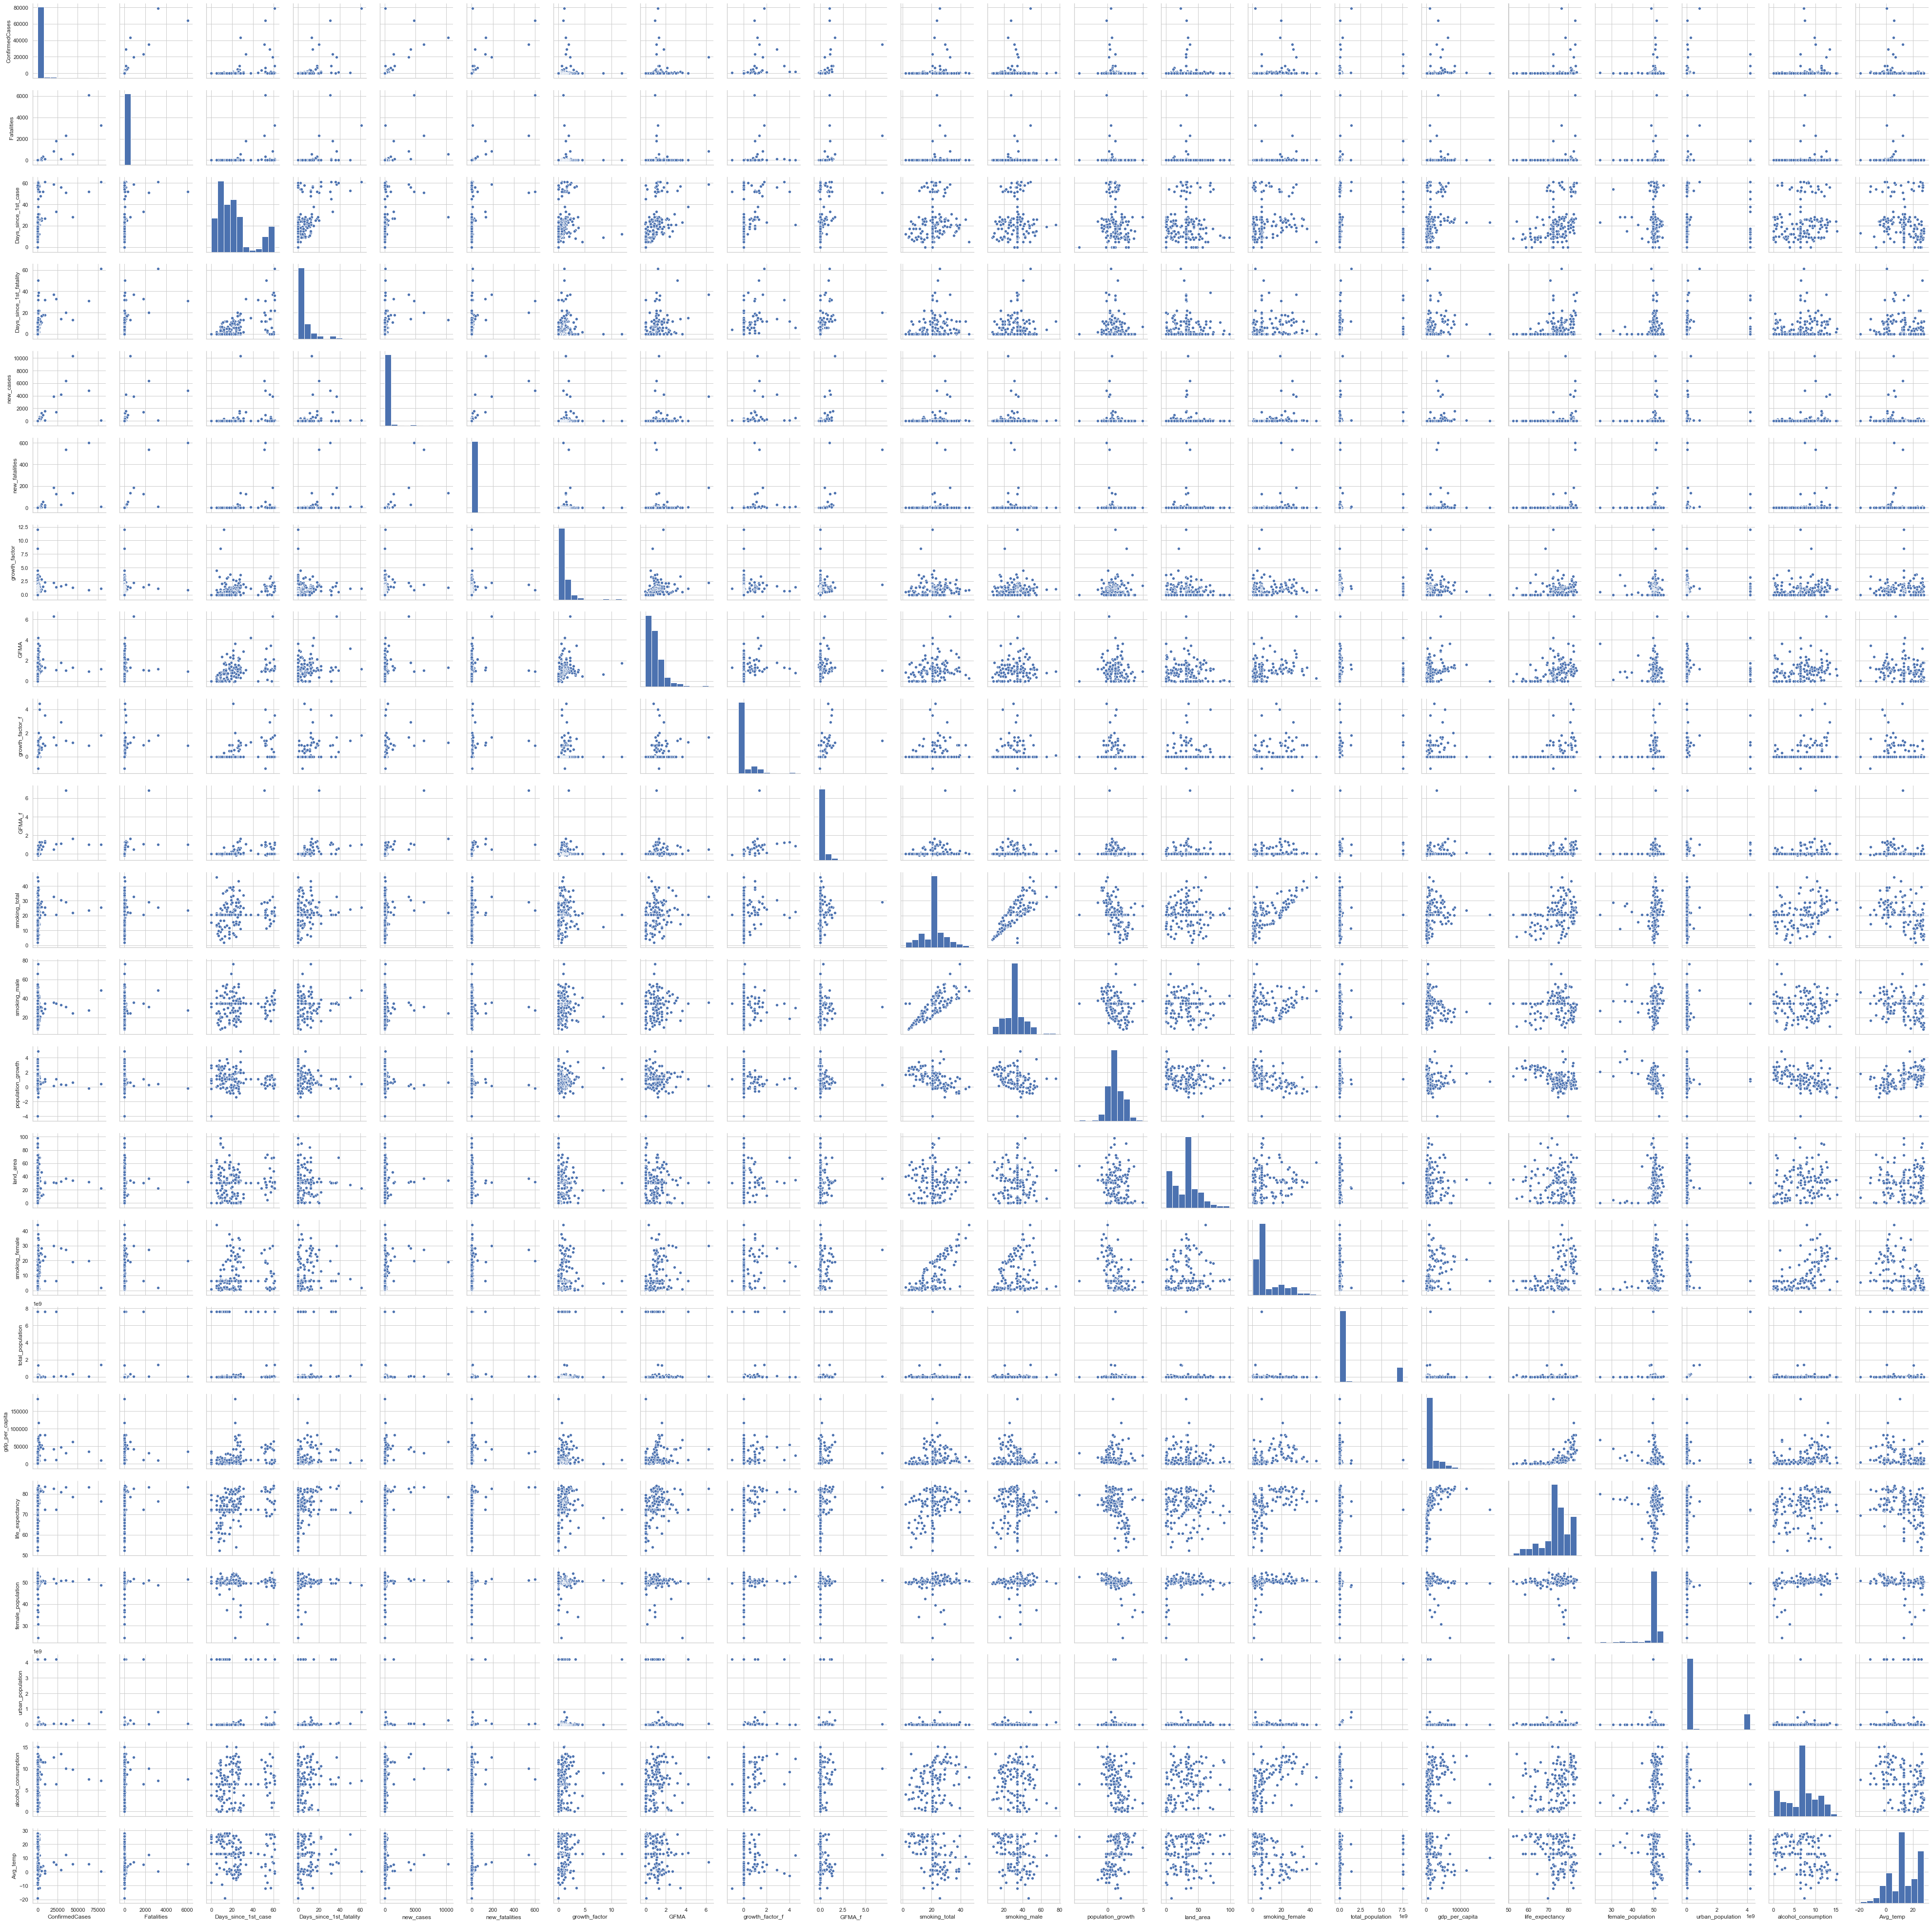

In [71]:
sns.pairplot(df_latest)

### Output to csv

Since I'm more familiar with modeling trees in R, this is how I'll check the features importances.

In [71]:
df_latest.to_csv('Kaggle/covid_train_grouped.csv', index = False)

In [72]:
df2.to_csv('Kaggle/covid_train.csv', index = False)

## Prediction Models

The influence of thos features was measured in a separate notebook running a Random Forest.

### [Times Series Smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)

In [73]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

In [78]:
def forecast(df_train, df_test,col,country,period,training_size = 0.8):
    
    temp = df_train[df_train['Region'] == country].copy()
    temp.set_index(pd.DatetimeIndex(temp['Date']), inplace = True)
    #temp.drop('Date', axis = 1, inplace = True)
    
    temp_pred = df_test[df_test['Region'] == country].copy()
    
    total_days = temp['Days_since_1st_case'].max()
    
    #Time Series Properties
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    tsaplots.plot_acf(temp[col], lags= 24, ax=ax[0])
    tsaplots.plot_pacf(temp[col], lags= 24, ax=ax[1])
    plt.show()
    
    decomposition = sm.tsa.seasonal_decompose(temp[col], freq = 12)
    fig = decomposition.plot()
    plt.show()
   
    #Model
    train = temp[col][temp['Days_since_1st_case'] <= total_days*training_size] #training default cut to 80% of dataset
    test = temp[col][temp['Days_since_1st_case'] > total_days*training_size]
    
    
    es = SimpleExpSmoothing(train).fit(smoothing_level=0.5)
    fore_es = es.forecast(temp_pred.shape[0])
     
    #holt = Holt(df.qtde[:'2018']).fit()
    #fore = holt.forecast(df.qtde['2018':].shape[0])
    holt = Holt(train).fit()
    fore_holt = holt.forecast(test.shape[0])
    pred_holt = holt.predict(test.shape[0])
        
    hw = ExponentialSmoothing(train, seasonal_periods=period, trend='add',seasonal='add').fit()
    fore_hw = hw.forecast(test.shape[0])
    #pred_hw = holt.predict(temp_pred.shape[0])
    
    plt.figure(figsize=(16,8))
    plt.plot(temp[col], label='Train')
    plt.plot(test, label='Test')
    plt.plot(fore_hw, label='Holt_Winters')
    plt.plot(fore_es, label='Exponential Smoothing')
    plt.plot(fore_holt, label='Holt Linear')
    
    plt.legend(loc='best')
    plt.show()

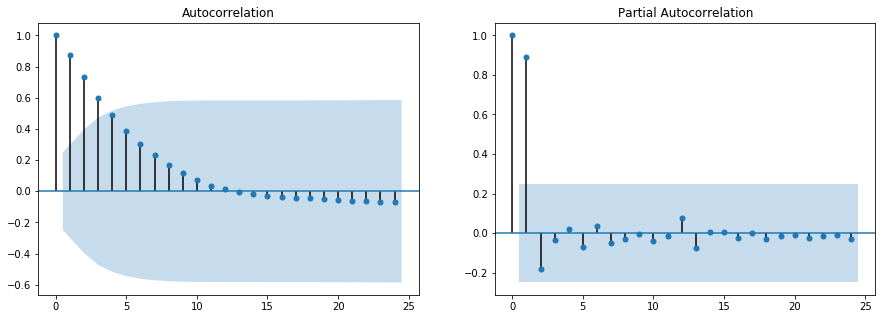

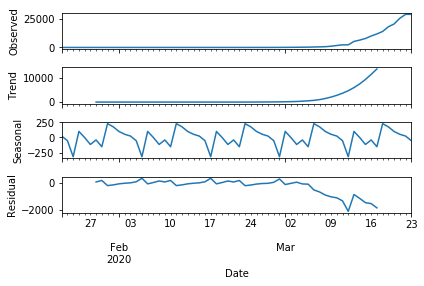

/Users/vivi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vivi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vivi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vivi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


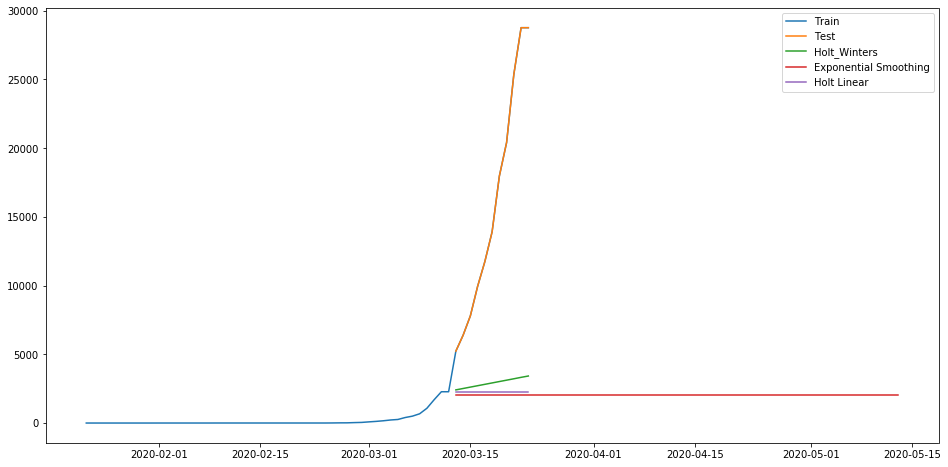

In [81]:
forecast(df2,df2,'Confirmed','Spain', 25, 0.8)